In [1]:
pip install pytorch-forecasting torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 7.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl

# 1. Import một số thư viện cần thiết

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor

import torch

from pytorch_forecasting import Baseline, NBeats, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, RMSE, MAPE, QuantileLoss

# 2. Load Data

In [5]:
from google.colab import files
uploaded = files.upload()

Saving MSN.csv to MSN.csv


In [6]:
df = pd.read_csv('MSN.csv')
df = df[['Price','Date']]

df = df.dropna() # Drop missing values
df["Price"] = df["Price"].str.replace(',', '').astype(float)

df["Date"] = pd.to_datetime(df["Date"].str.replace("/", "-"), format="%m-%d-%Y")
df = df.reset_index(drop=True) # Reset the index
df['time_idx'] = df.index
#df['month'] = df['Date'].dt.to_period('M')
df['time_series'] = 0
df

,Price,Date,time_idx,time_series
0,89000.0,2019-03-01,0,0
1,89500.0,2019-03-04,1,0
2,89400.0,2019-03-05,2,0
3,90000.0,2019-03-06,3,0
4,90000.0,2019-03-07,4,0
...,...,...,...,...
1310,75000.0,2024-05-29,1310,0
1311,77200.0,2024-05-30,1311,0
1312,76600.0,2024-05-31,1312,0
1313,77700.0,2024-06-03,1313,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Price        1315 non-null   float64       
 1   Date         1315 non-null   datetime64[ns]
 2   time_idx     1315 non-null   int64         
 3   time_series  1315 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 41.2 KB


# 3. Phân chia dữ liệu thành tập huấn luyện, kiểm tra và validation theo tỉ lệ 7:2:1

In [8]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# 4. Train network

In [9]:
max_encoder_length = 30
max_prediction_length = 90

train_dataset = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="Price",
    group_ids=["time_series"],
    time_varying_unknown_reals=["Price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

batch_size = 512

val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, test_data, predict=True)

val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4, pin_memory=True)
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1187: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
model_param = {
    "batch_normalization": True,
    "n_layers": 2,
    "n_blocks": [1, 1, 1],
}

In [11]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    train_dataset,
    learning_rate=3e-2,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    **model_param
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01584893192461114
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01584893192461114
INFO: Restoring states from the checkpoint path at /content/.lr_find_1be17dfe-f4ea-4891-971e-e81a5c2d1d9b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_1be17dfe-f4ea-4891-971e-e81a5c2d1d9b.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_1be17dfe-f4ea-4891-971e-e81a5c2d1d9b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_1be17dfe-f4ea-4891-971e-e81a5c2d1d9b.ckpt


suggested learning rate: 0.01584893192461114


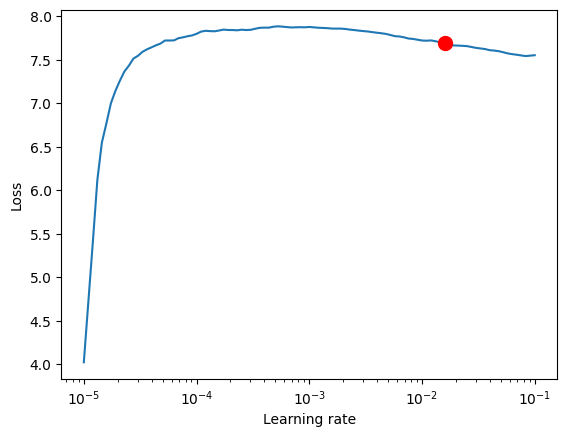

In [12]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [13]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
    log_every_n_steps = 10,
)


net = NHiTS.from_dataset(
    train_dataset,
    learning_rate=res.suggestion(),
    log_interval=1,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=1.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=RMSE(),
    **model_param
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | RMSE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 27.2 K | train
-----------------------------------------------------------
27.2 K    Trainable params
0         Non-trainable params
27.2 K    Total params
0.109     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type           | Params | Mode 
--

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# 5. Evaluate Results

In [14]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [15]:
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


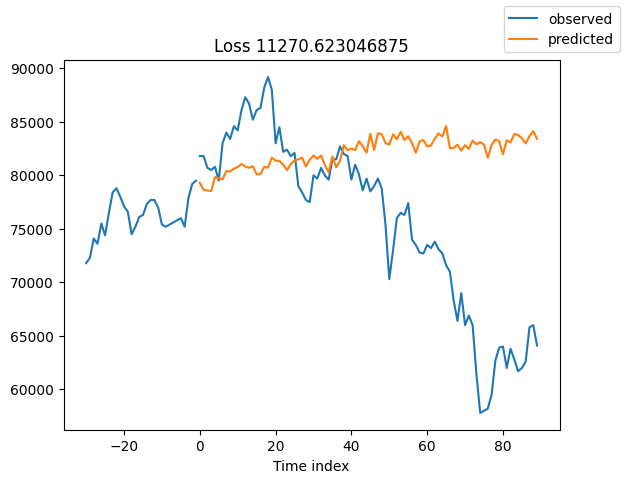

In [16]:
for idx in range(1):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

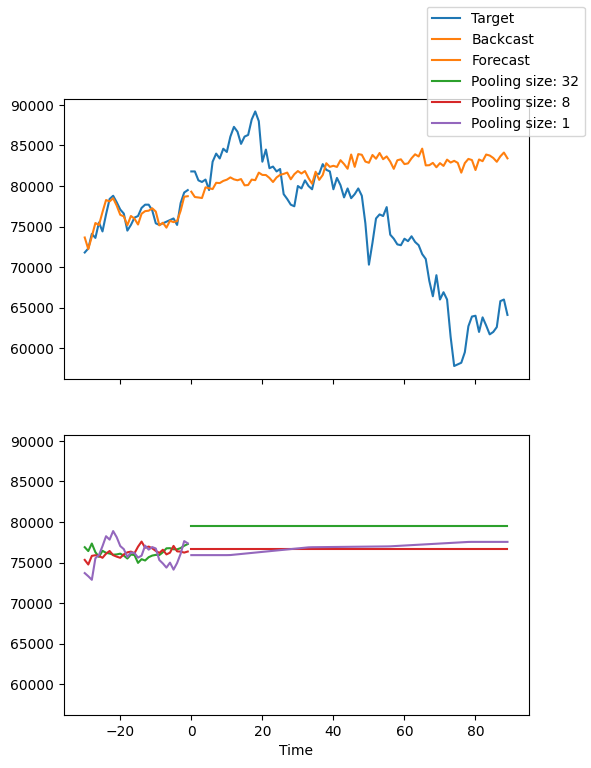

In [17]:
for idx in range(1):
    best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=idx)

# 6. Đánh giá độ chính xác thuật toán

In [18]:
MAPE()(predictions.output, predictions.y)*100

tensor(12.5873)

In [19]:
RMSE()(predictions.output, predictions.y)

tensor(11270.6230)

In [20]:
MAE()(predictions.output, predictions.y)

tensor(8582.7148)

# 7. Vẽ hình

In [35]:
output_list = predictions.output.numpy().tolist()
output_array = np.array(output_list)
output_array = output_array.flatten()

dataset_30 = output_array[:30]
dataset_60 = output_array[30:60]
dataset_90 = output_array[60:90]

In [36]:
from datetime import timedelta
last_date = df['Date'].max()

next_30_days = [last_date + timedelta(days=i) for i in range(1, 31)]
next_60_days = [last_date + timedelta(days=i) for i in range(31, 61)]
next_90_days = [last_date + timedelta(days=i) for i in range(61, 91)]

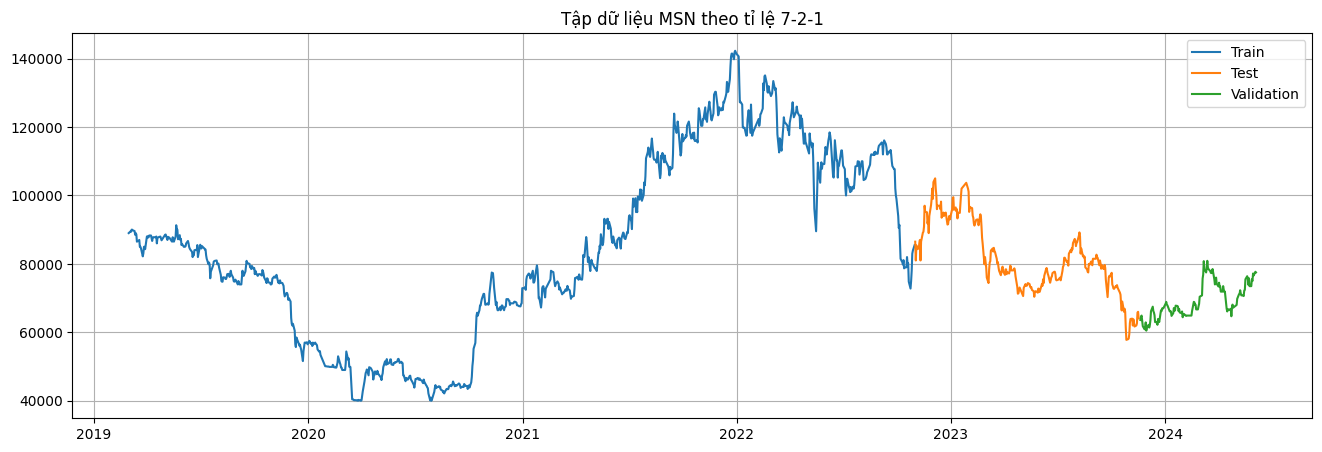

In [37]:
#Drawing plot
plt.figure(figsize=(16,5))
plt.title("Tập dữ liệu MSN theo tỉ lệ 7-2-1")
plt.grid(True)
plt.plot(train_data.Date, train_data['Price'])
plt.plot(test_data.Date, test_data['Price'])
plt.plot(val_data.Date, val_data['Price'])
plt.legend(['Train', 'Test', 'Validation'])
plt.show()

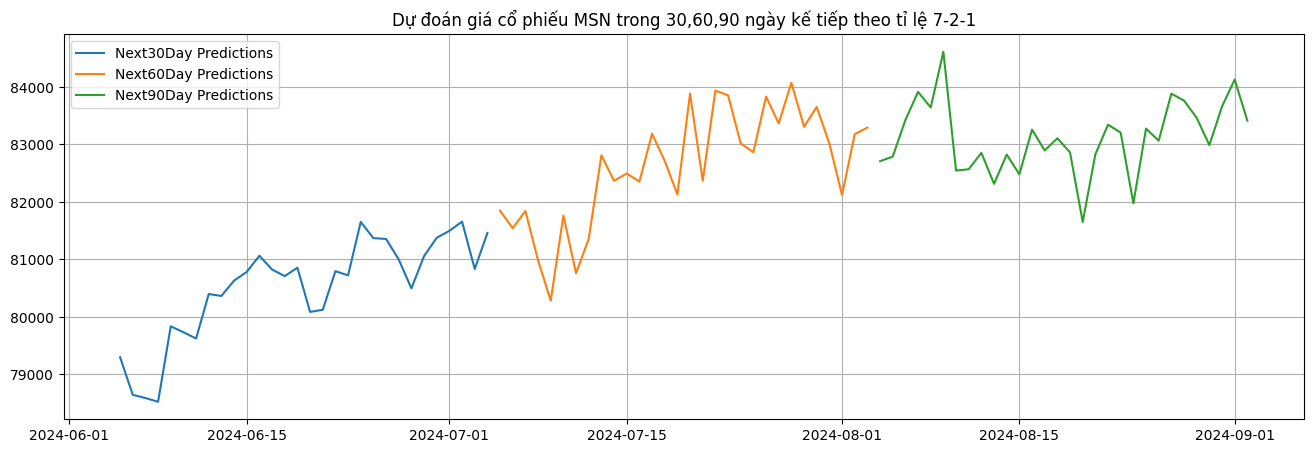

In [38]:
plt.figure(figsize=(16,5))
plt.title("Dự đoán giá cổ phiếu MSN trong 30,60,90 ngày kế tiếp theo tỉ lệ 7-2-1")
plt.grid(True)
plt.plot(next_30_days,dataset_30)
plt.plot(next_60_days,dataset_60)
plt.plot(next_90_days,dataset_90)
plt.legend(['Next30Day Predictions','Next60Day Predictions','Next90Day Predictions'])
plt.show()

# 8. Phân chia dữ liệu thành tập huấn luyện, kiểm tra và validation theo tỉ lệ 6:3:1

In [40]:
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# 9. Train network

In [41]:
max_encoder_length = 30
max_prediction_length = 90

train_dataset = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="Price",
    group_ids=["time_series"],
    time_varying_unknown_reals=["Price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

batch_size = 512

val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, test_data, predict=True)

val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4, pin_memory=True)
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1187: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [42]:
model_param = {
    "batch_normalization": True,
    "n_layers": 2,
    "n_blocks": [1, 1, 1],
}

In [43]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    train_dataset,
    learning_rate=3e-2,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    **model_param
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.007585775750291836
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.007585775750291836
INFO: Restoring states from the checkpoint path at /content/.lr_find_c53cc707-9c59-477a-987b-36dbe241ff7c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_c53cc707-9c59-477a-987b-36dbe241ff7c.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_c53cc707-9c59-477a-987b-36dbe241ff7c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_c53cc707-9c59-477a-987

suggested learning rate: 0.007585775750291836


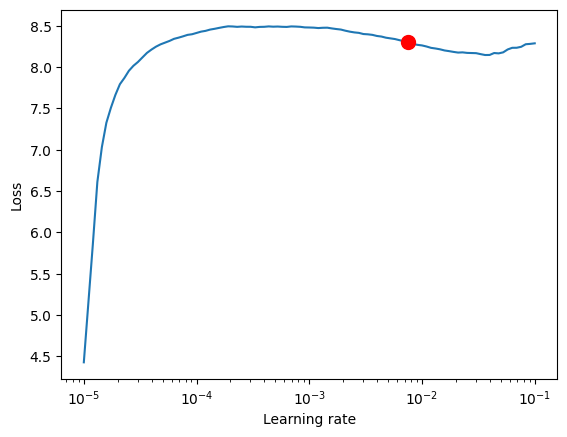

In [44]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [45]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
    log_every_n_steps = 10,
)


net = NHiTS.from_dataset(
    train_dataset,
    learning_rate=res.suggestion(),
    log_interval=1,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=1.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=RMSE(),
    **model_param
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | RMSE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 27.2 K | train
-----------------------------------------------------------
27.2 K    Trainable params
0         Non-trainable params
27.2 K    Total params
0.109     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type           | Params | Mode 
--

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# 10. Evaluate Results

In [46]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [47]:
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


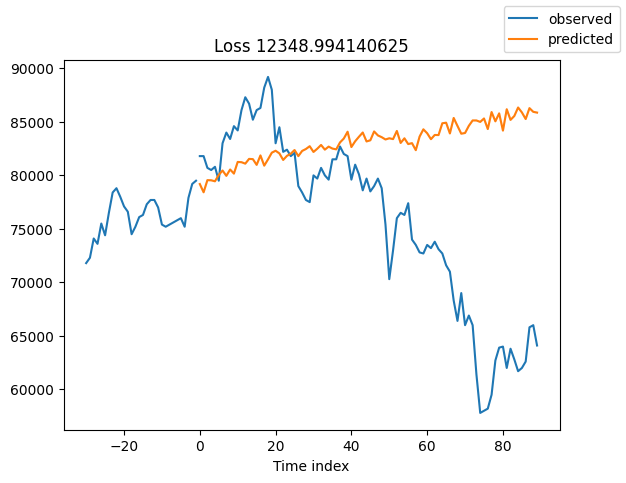

In [48]:
for idx in range(1):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

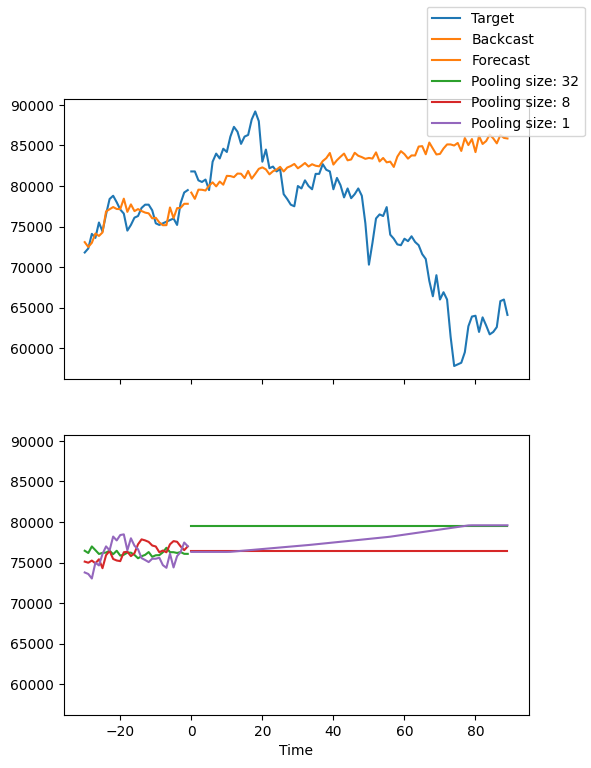

In [49]:
for idx in range(1):
    best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=idx)

# 11. Đánh giá độ chính xác thuật toán

In [50]:
MAPE()(predictions.output, predictions.y)*100

tensor(13.6594)

In [51]:
RMSE()(predictions.output, predictions.y)

tensor(12348.9941)

In [52]:
MAE()(predictions.output, predictions.y)

tensor(9271.9580)

# 12. Vẽ Hình

In [53]:
output_list = predictions.output.numpy().tolist()
output_array = np.array(output_list)
output_array = output_array.flatten()

dataset_30 = output_array[:30]
dataset_60 = output_array[30:60]
dataset_90 = output_array[60:90]

In [54]:
from datetime import timedelta
last_date = df['Date'].max()

next_30_days = [last_date + timedelta(days=i) for i in range(1, 31)]
next_60_days = [last_date + timedelta(days=i) for i in range(31, 61)]
next_90_days = [last_date + timedelta(days=i) for i in range(61, 91)]

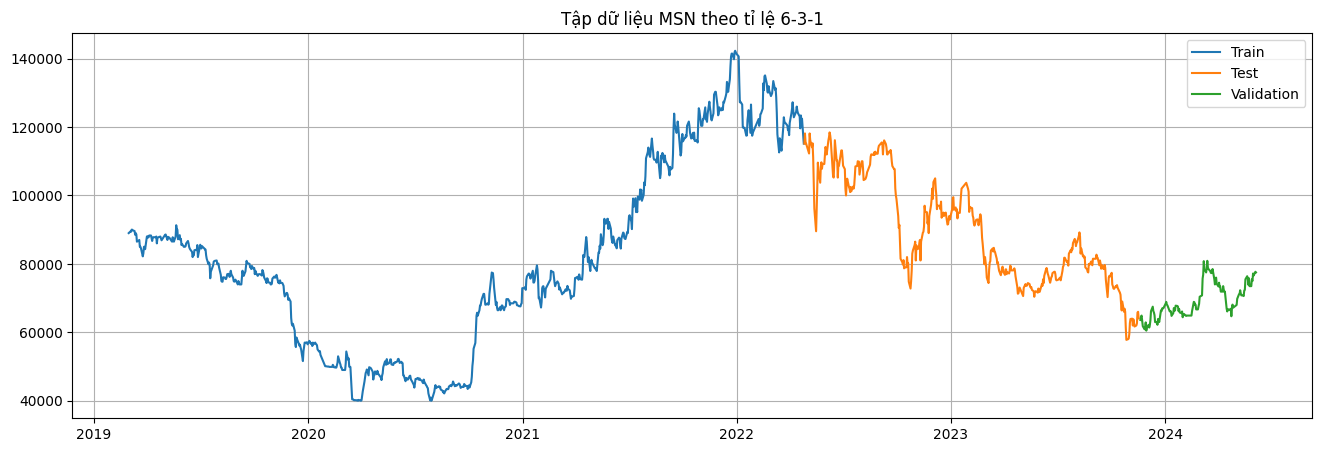

In [55]:
#Drawing plot
plt.figure(figsize=(16,5))
plt.title("Tập dữ liệu MSN theo tỉ lệ 6-3-1")
plt.grid(True)
plt.plot(train_data.Date, train_data['Price'])
plt.plot(test_data.Date, test_data['Price'])
plt.plot(val_data.Date, val_data['Price'])
plt.legend(['Train', 'Test', 'Validation'])
plt.show()

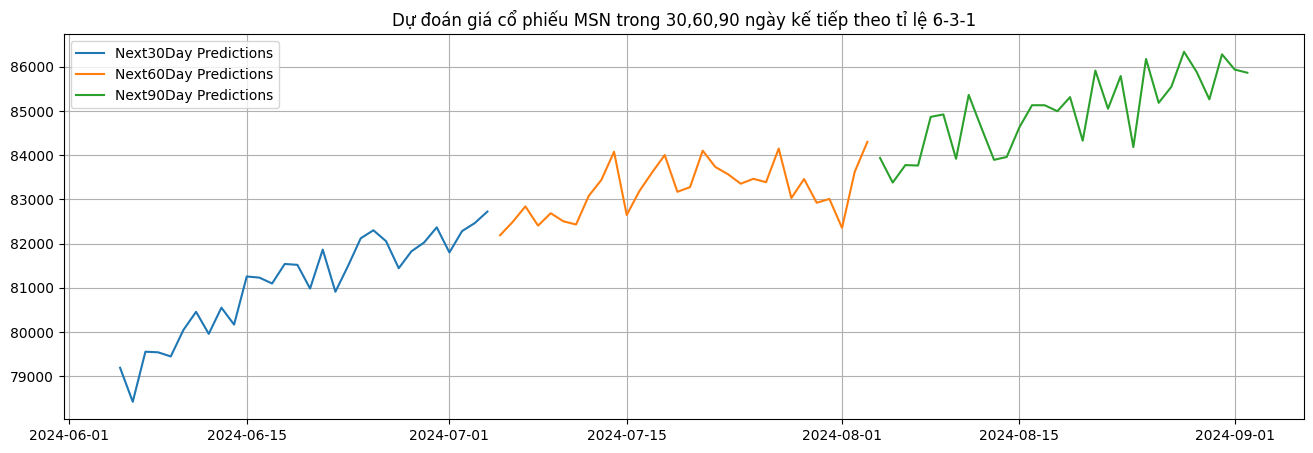

In [56]:
plt.figure(figsize=(16,5))
plt.title("Dự đoán giá cổ phiếu MSN trong 30,60,90 ngày kế tiếp theo tỉ lệ 6-3-1")
plt.grid(True)
plt.plot(next_30_days,dataset_30)
plt.plot(next_60_days,dataset_60)
plt.plot(next_90_days,dataset_90)
plt.legend(['Next30Day Predictions','Next60Day Predictions','Next90Day Predictions'])
plt.show()

# 13. Phân chia dữ liệu thành tập huấn luyện, kiểm tra và validation theo tỉ lệ 5:3:2

In [58]:
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# 14. Train network

In [59]:
max_encoder_length = 30
max_prediction_length = 90

train_dataset = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="Price",
    group_ids=["time_series"],
    time_varying_unknown_reals=["Price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

batch_size = 512

val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, test_data, predict=True)

val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4, pin_memory=True)
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1187: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [60]:
model_param = {
    "batch_normalization": True,
    "n_layers": 2,
    "n_blocks": [1, 1, 1],
}

In [61]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    train_dataset,
    learning_rate=3e-2,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    **model_param
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013182567385564076
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013182567385564076
INFO: Restoring states from the checkpoint path at /content/.lr_find_eae0616d-351e-414c-b209-d466efec5c41.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_eae0616d-351e-414c-b209-d466efec5c41.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_eae0616d-351e-414c-b209-d466efec5c41.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_eae0616d-351e-414c-b20

suggested learning rate: 0.013182567385564076


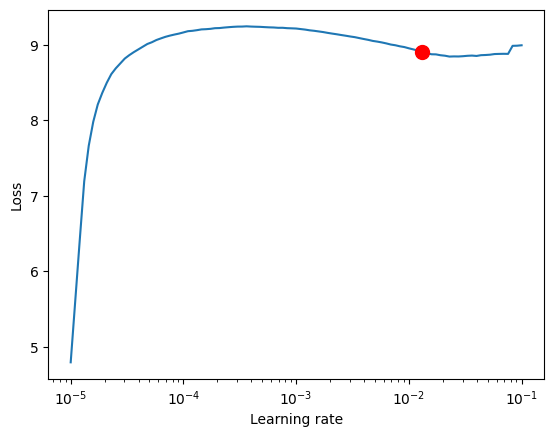

In [62]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [63]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
    log_every_n_steps = 10,
)


net = NHiTS.from_dataset(
    train_dataset,
    learning_rate=res.suggestion(),
    log_interval=1,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=1.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=RMSE(),
    **model_param
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | RMSE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 27.2 K | train
-----------------------------------------------------------
27.2 K    Trainable params
0         Non-trainable params
27.2 K    Total params
0.109     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type           | Params | Mode 
--

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# 15. Evaluate Results

In [64]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [65]:
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


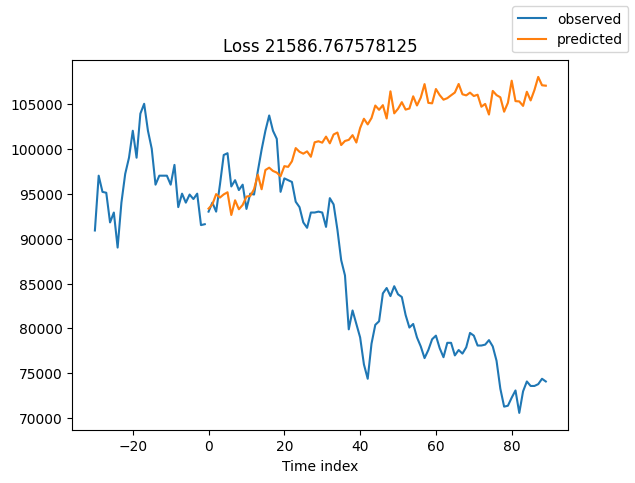

In [66]:
for idx in range(1):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

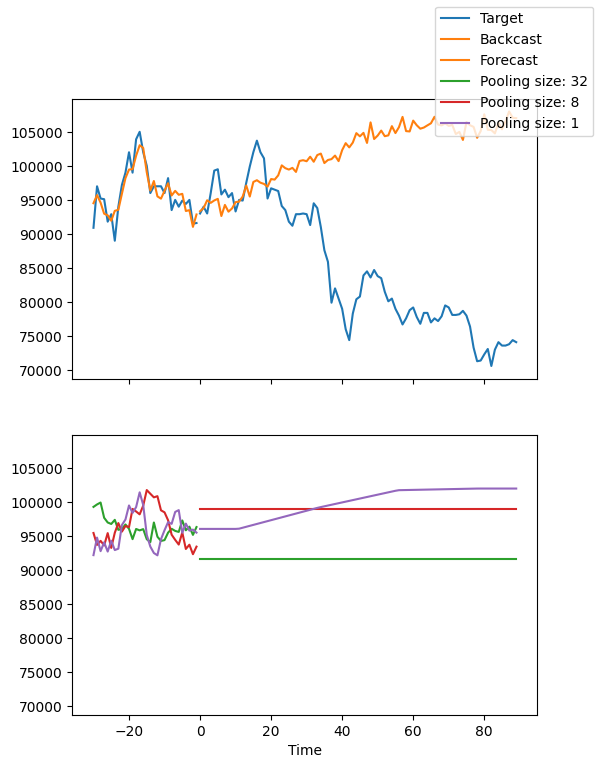

In [67]:
for idx in range(1):
    best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=idx)

# 16. Đánh giá độ chính xác thuật toán

In [68]:
MAPE()(predictions.output, predictions.y)*100

tensor(22.9703)

In [69]:
RMSE()(predictions.output, predictions.y)

tensor(21586.7676)

In [70]:
MAE()(predictions.output, predictions.y)

tensor(18050.5137)

# 17. Vẽ Hình

In [71]:
output_list = predictions.output.numpy().tolist()
output_array = np.array(output_list)
output_array = output_array.flatten()

dataset_30 = output_array[:30]
dataset_60 = output_array[30:60]
dataset_90 = output_array[60:90]

In [72]:
last_index = df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

In [73]:
from datetime import timedelta
last_date = df['Date'].max()

next_30_days = [last_date + timedelta(days=i) for i in range(1, 31)]
next_60_days = [last_date + timedelta(days=i) for i in range(31, 61)]
next_90_days = [last_date + timedelta(days=i) for i in range(61, 91)]

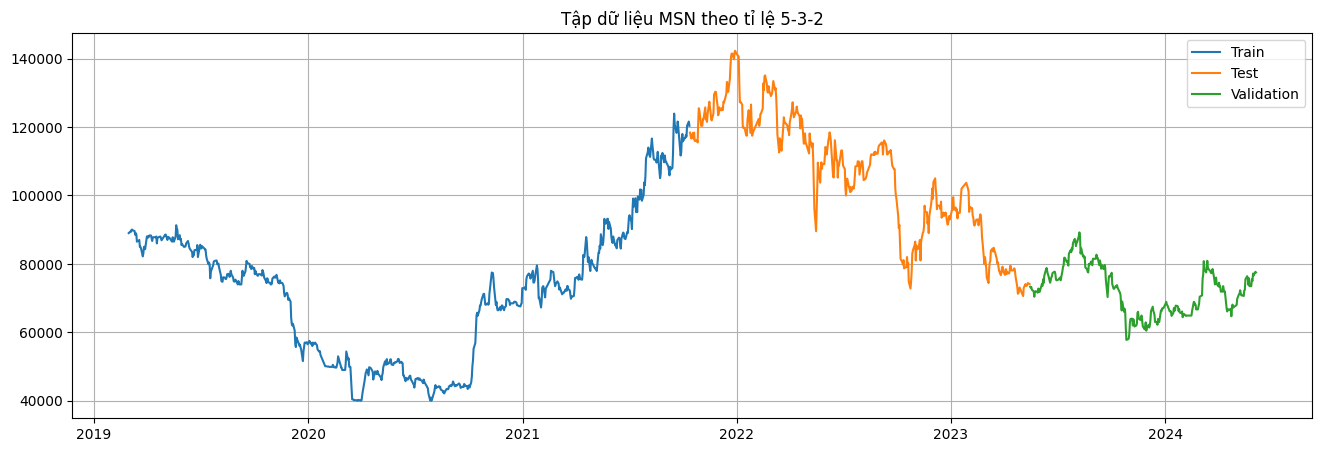

In [74]:
#Drawing plot
plt.figure(figsize=(16,5))
plt.title("Tập dữ liệu MSN theo tỉ lệ 5-3-2")
plt.grid(True)
plt.plot(train_data.Date, train_data['Price'])
plt.plot(test_data.Date, test_data['Price'])
plt.plot(val_data.Date, val_data['Price'])
plt.legend(['Train', 'Test', 'Validation'])
plt.show()

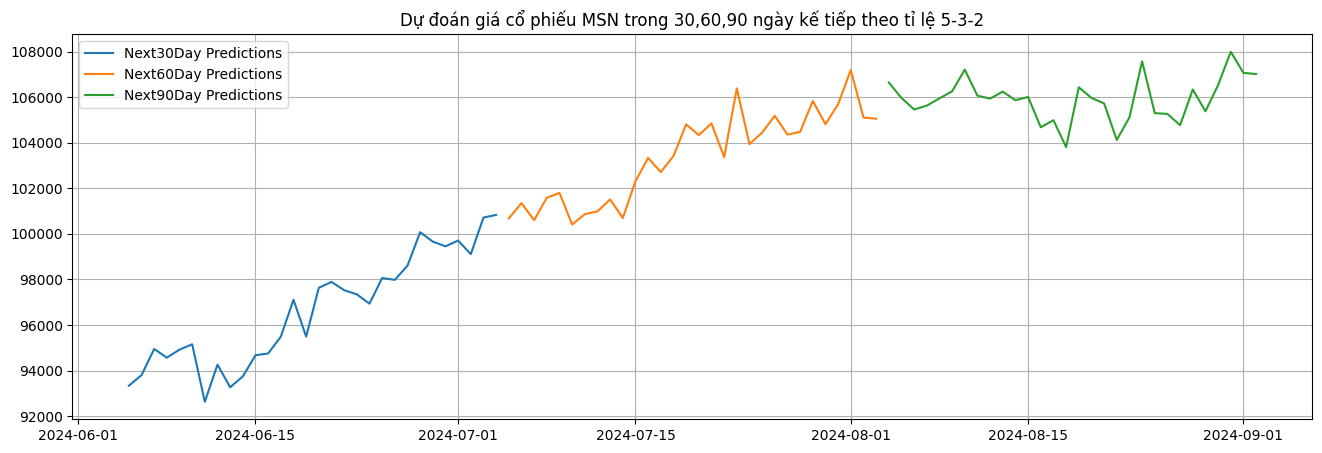

In [75]:
plt.figure(figsize=(16,5))
plt.title("Dự đoán giá cổ phiếu MSN trong 30,60,90 ngày kế tiếp theo tỉ lệ 5-3-2")
plt.grid(True)
plt.plot(next_30_days,dataset_30)
plt.plot(next_60_days,dataset_60)
plt.plot(next_90_days,dataset_90)
plt.legend(['Next30Day Predictions','Next60Day Predictions','Next90Day Predictions'])
plt.show()